<div style="border: 5px solid; border-color: rgb(226, 73, 50); border-radius: 35px; position: relative; width: 95%; height: 400px; display: flex; justify-content: center; align-items: center; background-color: #f0f0f0;">
    <img src="https://media.istockphoto.com/id/1351881144/vector/email-marketing-banner-ui-newsletter-news-offers-promotions-subscription-follow-us-concept.jpg?s=612x612&w=0&k=20&c=XxgTzFxywWp7H3-7Vuivs7p-jZz2a32e0Af6Prjrx9A=" style="position: absolute; top: 0; left: 0; width: 100%; height: 100%; z-index: 0; opacity: 1.0; border-radius: 30px">
    <div style="position: relative; z-index: 1; text-align: center; background-color: rgba(3, 40, 21, 0.2); color: orange; display: flex; flex-direction: column; align-items: center; text-align: center; justify-content: center; width: 100%; border-radius: 20px">
        <h1 style="text-align: center; width: 100%; font-size: 72px; color:rgb(226, 73, 50)" ><b>Email Spam Detection</b></h1>
    </div>
</div>

# <div style="width: 100%"><h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgb(157, 213, 105); background-color: rgba(226,  73,  50, 0.5); padding: 30px; border: 5px solid rgb(157, 213, 105); border-style: solid; border-radius: 10px;"> Imports & Load Data </h1></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
base_path = "/kaggle/input/email-spam-classification-dataset-csv/emails.csv"
df = pd.read_csv(base_path)
TARGET = 'Prediction'

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()
sns.set_palette('RdYlGn')
SNS_CMAP = 'RdYlGn'

colors = sns.palettes.color_palette(SNS_CMAP)
pd.options.mode.chained_assignment = None

In [34]:
import cupy as cp
import cuml
import copy

from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, precision_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [7]:
df

,the,to,ect,and,for,of,a,you,hou,in,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,0,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,13,24,6,6,2,102,1,27,18,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,8,0,0,4,...,0,0,0,0,0,0,0,0,0,0
3,0,5,22,0,5,1,51,2,10,1,...,0,0,0,0,0,0,0,0,0,0
4,7,6,17,1,5,2,57,0,9,3,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,2,2,2,3,0,0,32,0,0,5,...,0,0,0,0,0,0,0,0,0,0
5168,35,27,11,2,6,5,151,4,3,23,...,0,0,0,0,0,0,0,1,0,0
5169,0,0,1,1,0,0,11,0,0,1,...,0,0,0,0,0,0,0,0,0,1
5170,2,7,1,0,2,1,28,2,0,8,...,0,0,0,0,0,0,0,1,0,1


<div style="margin: 0% 15%; text-align: center; font-family: 'Roboto', sans-serif; background-color: rgba(226,  73,  50, 0.15); padding: 20px; border-style: solid; border-radius: 10px;">
    <h3>Using cupy</h3>
    <p>
        We will convert to cupy and cuDf to leverage accelerated compute as the data is very high dimensional
<br>        
 <br>
We may also drop 'O' columns for now for easy computations
    </p>
</div>

In [24]:
cuml.set_global_output_type('cupy')
df = df.select_dtypes('int')

X = cp.asarray(df.select_dtypes('int'))
y = cp.asarray(df[TARGET])
X.shape, y.shape

((5172, 3001), (5172,))

In [9]:
!nvidia-smi

Fri Oct 18 16:48:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P0             29W /   70W |     225MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [87]:
def print_classification_metrics_cv_cuml(model, X, y, cv=5):
    """
    SPECIALLY FOR CUML AND SUPPORTS cupy arrays
    Returns classification metrics for provided *cuml* model using cv
    Args:
        model: A cuml instantiated classification model 
        X: cupy Feature matrix.
        y: cupy Target variable.
        cv: Number of cross-validation folds (default=5).

    Returns:
        tuple: Cross-validated accuracy, AUC-ROC, and precision scores.
    """
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = { 'f1': [], 'accuracy': [], 'roc_auc': [], }
    X, y = X.get(), y.get()
    true_labels = []
    predicted_probs = []
    confusion_matrix_sum = np.zeros((2, 2))
    bad_probas= False
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, y_train = cp.asarray(X_train), cp.asarray(y_train)
        model_fold = copy.deepcopy(model)
        model_fold.fit(X_train, y_train)
        
        y_pred = model_fold.predict(X_test).get()
        try:
            y_proba = model_fold.predict_proba(X_test).get()
        except:
            bad_probas = True
            y_proba = np.stack([np.zeros_like(y_test), np.ones_like(y_test)], axis=-1)
        scores['f1'].append(f1_score(y_test, y_pred, average='binary')) 
        scores['accuracy'].append(accuracy_score(y_test, y_pred))
        scores['roc_auc'].append(roc_auc_score(y_test, y_proba[:, 1]))  

        confusion_matrix_sum += confusion_matrix(y_test, y_pred)
        true_labels.extend(y_test)
        predicted_probs.extend(y_proba[:, 1])

    f1_scores = np.mean(scores['f1'])
    accuracy_scores = np.mean(scores['accuracy'])
    auc_roc_scores = np.mean(scores['roc_auc'])
    
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    print(clrd(model, 'log'))
    if bad_probas:
        print(clrd("Error calculating AUC_ROC scores", 'error'))
    print(f"Accuracy: {accuracy_scores:.4f}   AUC-ROC: {auc_roc_scores:.4f}   F1: {f1_scores:.4f}")
    print('=' * 70)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.heatmap(confusion_matrix_sum.astype(int), annot=True, cmap='Greens', cbar=False, ax=ax[0])
    ax[0].set_title("Confusion Matrix")
    ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_title("AUC_ROC curve")
    plt.show()
    
def clrd(text: str, color: str = None):
    color_codes = {
        'ok': '\033[92m',        # Green
        'error': '\033[91m',     # Red
        'warning': '\033[93m',   # Yellow
        'success': '\033[92m',   # Green
        'status': '\033[95m',    # Magenta
        'special': '\033[94m',   # Blue
        'log': '\033[96m',       # Cyan
        'reset': '\033[0m'       # Reset to default color
    }
    color_code = color_codes.get(color, color_codes['reset'])
    return f"{color_code}{text}{color_codes['reset']}"

# <div style="width: 100%"><h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgb(157, 213, 105); background-color: rgba(226,  73,  50, 0.5); padding: 30px; border: 5px solid rgb(157, 213, 105); border-style: solid; border-radius: 10px;"> KNN </h1></div>

KNeighborsClassifier()
Accuracy: 0.8670   AUC-ROC: 0.9332   F1: 0.7861


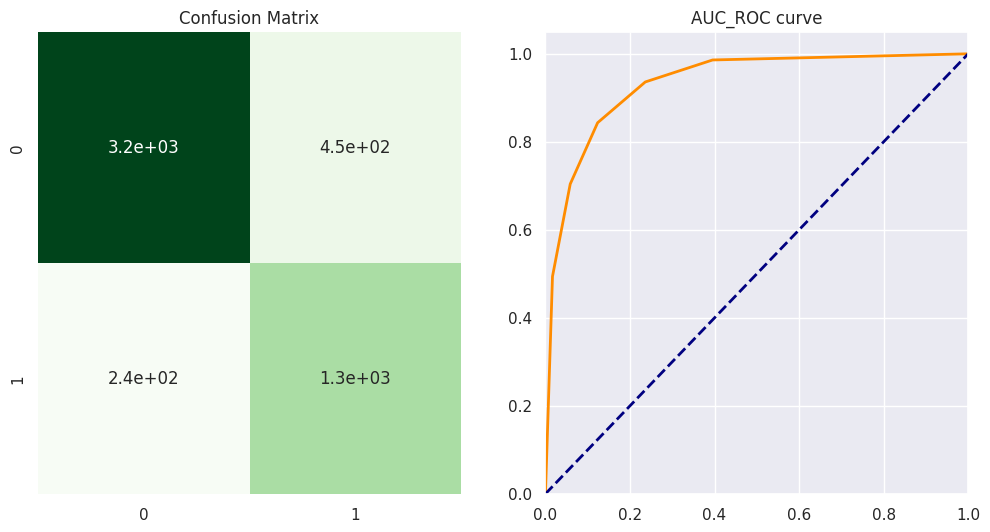

CPU times: user 1.36 s, sys: 295 ms, total: 1.66 s
Wall time: 1.39 s


In [88]:
%%time
knn = cuml.neighbors.KNeighborsClassifier()
print_classification_metrics_cv_cuml(knn, X, y)

# <div style="width: 100%"><h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgb(157, 213, 105); background-color: rgba(226,  73,  50, 0.5); padding: 30px; border: 5px solid rgb(157, 213, 105); border-style: solid; border-radius: 10px;"> SVM </h1></div>

SVC()
Error calculating AUC_ROC scores
Accuracy: 0.8061   AUC-ROC: 0.5000   F1: 0.5392


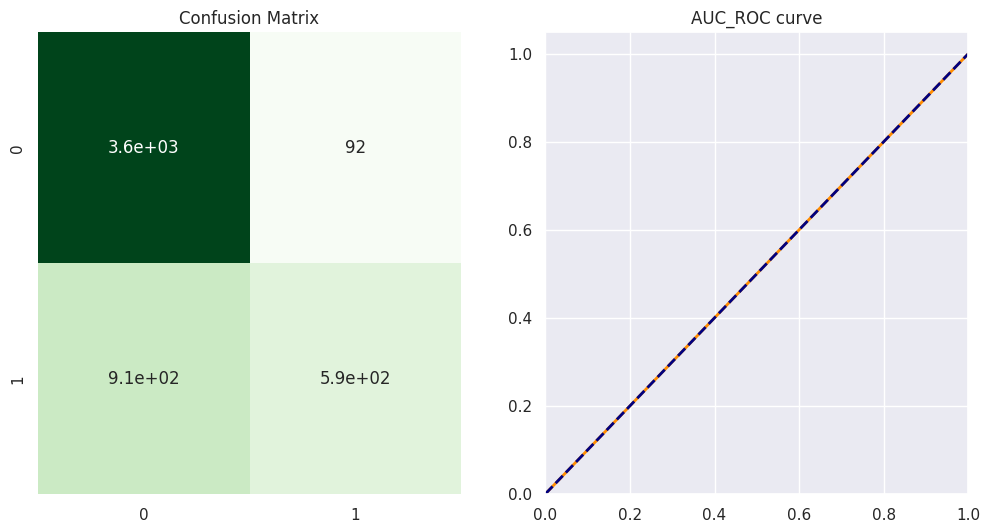

CPU times: user 1.18 s, sys: 262 ms, total: 1.44 s
Wall time: 1.17 s


In [89]:
%%time
svc_classifier = cuml.SVC()
print_classification_metrics_cv_cuml(svc_classifier, X.astype('float32'), y.astype('float32'))

[W] [17:51:47.098198] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.
SVC()
Error calculating AUC_ROC scores
Accuracy: 0.9981   AUC-ROC: 0.5000   F1: 0.9967


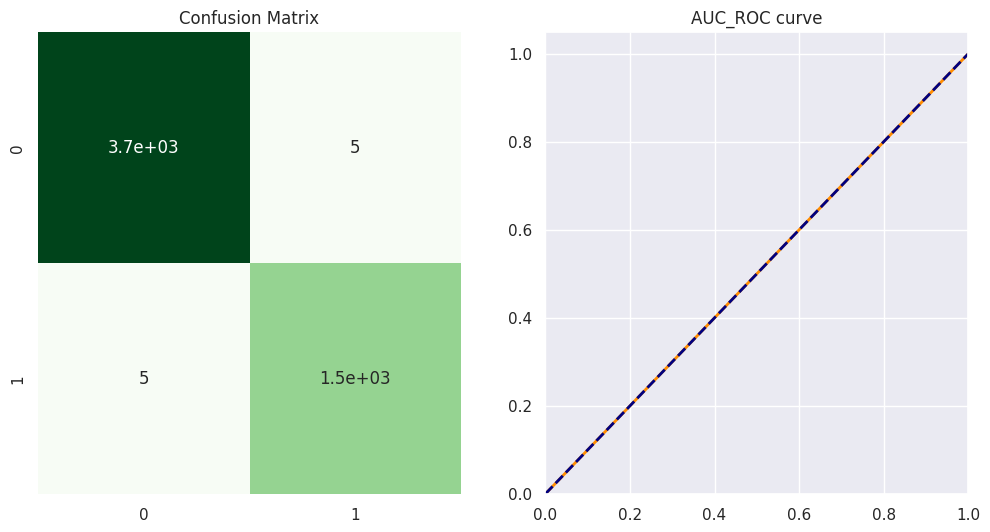

CPU times: user 2.98 s, sys: 239 ms, total: 3.22 s
Wall time: 2.95 s


In [90]:
%%time
svc_classifier = cuml.SVC(kernel='linear')
print_classification_metrics_cv_cuml(svc_classifier, X.astype('float32'), y.astype('float32'))